# QWOP AI

Direct screen capture for observation. Make sure QWOP is in Chrome and window is resized just before scroll bars appear. Place window in top-left of screen. Note that this project is intended to be run *locally* on a computer where you can easily set up the game window for screen capture.

Based on the "Build a Chrome Dino Game AI Model with Python" video by Nicholas Renotte: https://www.youtube.com/watch?v=vahwuupy81A

## Install dependencies

### Prerequisites

You will need to install OpenCV. The easiest way to do this is from the Anaconda environment. The newest version might work, but 4.7.0 worked for this notebook. You will also need [tesserocr](https://pypi.org/project/tesserocr/) for doing optical character recognition (OCR). Version 2.5.2 was verified working for this notebook.

```
conda install -c conda-forge opencv=4.7.0 tesserocr=2.5.2
```

Finally, you will need to install PyTorch for Stable Baselines3 to work. It is highly recommended that you use the GPU-enabled version of PyTorch for faster training. Follow the directions here: https://pytorch.org/get-started/locally/. This notebook was tested with the following:
 * PyTorch v2.0.0
 * OS: Windows
 * Package: Conda
 * Language: Python
 * Compute platform: CUDA 11.7

### Install packages

Uncomment the following cells to install the required packages. Note the versions on some of them. Gymnasium and Stable-Baselines3 change constantly, so I tried to version-lock these packages, as these are known to work with this notebook. Starting with v2.0.0, Stable-Baselines3 will only support gymnasium (and drop gym support). See [here](https://github.com/DLR-RM/stable-baselines3/releases/tag/v1.8.0) for more information.

In [ ]:
# !python -m pip install mss pynput 
# !python -m pip install gymnasium==0.28.1
# !python -m pip install stable-baselines3[extra]==2.0.0a1
# !python -m pip install wandb

In [ ]:
# !pip install Cmake

In [ ]:
# !pip install opencv
# !pip install tesserocr

In [3]:
!python --version

Python 3.10.12


## Configuration

In [1]:
### Import libraries

# Screen capture
from mss import mss

# Sending commands (e.g. mouse/keyboard)
import pynput

# OpenCV for image manipulation
import cv2

# Optical character recognition (OCR)
import tesserocr
from PIL import Image

# Farama Foundation Gymnasium (fork of OpenAI gym)
import gymnasium as gym

# Reinforcement model modules
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import KVWriter, Logger
from stable_baselines3 import PPO, DQN

# Weights & Biases for remote logging
import wandb

# Other
import time
import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from typing import Any, Dict, Tuple, Union

In [2]:
### Settings

# Game observation
GAME_CROP = {
    'top':410, 
    'left':300, 
    'width':480, 
    'height':320
}

# Image resize (minimum of 36x36 for default CnnPolicies)
GAME_RESIZE_WIDTH = 96
GAME_RESIZE_HEIGHT = 96
GAME_FRAME_STACK_SIZE = 4

# How big to make display image (0 for no display)
DISP_SCALE_FACTOR = 3.0

# Where to find the head/hair in the scaled game image
HEAD_ROW_MIN = 1
HEAD_ROW_MAX = 96
HEAD_PIXEL_THRESHOLD = 34
HEAD_HEIGHT_THRESHOLD = 23

# Score observation
SCORE_CROP = {
    'top':375, 
    'left':280, 
    'width':380, 
    'height':42
}
SCORE_RESIZE_WIDTH = 300
SCORE_RESIZE_HEIGHT = 40

# Game over screen
DONE_CROP = {
    'top':610, 
    'left':370, 
    'width':100, 
    'height':30}
DONE_RESIZE_WIDTH = 150
DONE_RESIZE_HEIGHT = 40
GAME_OVER_STRINGS = ["press"]

# Action settings
RESTART_MOUSE_POS = (300, 600)
RESTART_KEY = 'r'
ACTIONS_KEY_PRESS_TIME = 0.1
ACTIONS_MAP = {
    0: 'no-op',
    1: 'press q',
    2: 'press w',
    3: 'press qp',
    4: 'press wo'
}

# Reward settings
FALL_REWARD = -20
KNEEL_REWARD = 0
SCORE_MULTIPLIER = 5
GOAL_MARKER = 20
GOAL_REWARD = 100
LONG_PRESS_THRESHOLD = 0.5  # Seconds
LONG_PRESS_REWARD = 0

# CnnPolicy requires 8-bit unsigned integers for images
DTYPE = np.uint8

# Size of sliding window average to calculate FPS
FPS_AVG_LEN = 30

# Checkpoint config
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_FREQ = 25_000 # 25k steps with 15 fps is about 30 min

# Log config
LOG_DIR = "logs"
LOG_FREQ = 5_000 # 5k steps with 30 fps is about 5 min

# Weights & Biases configuratino
WANDB_PROJECT = "qwop"

## Test Screen Capture

The following cells are used to test capturing screens and performing OCR. Such actions will be incorporated into the custom gymnasium Environment (Env) wrapper.

In [3]:
### Create screen capture object
screen = mss()

Shape: (96, 96)
Example row: [ 25  25  24  24  23  32  33  33  33  32  22  22  21  21  19  20  20  21
  20  21  26  31  31  31  31  23  21  22  22  21  23  23  23  24  24  24
  24  24  25  25  25  26  26  26  26  27  27  27  27  27  27  27  25  29
  71  90  74  88 104 100  90  79  28  29  29  30  30  30  31  31  32  32
  32  34  34  34  36  36  36  37  37  37  38  38  41  38  60 118 119 115
 117 117 118 118 118 120]


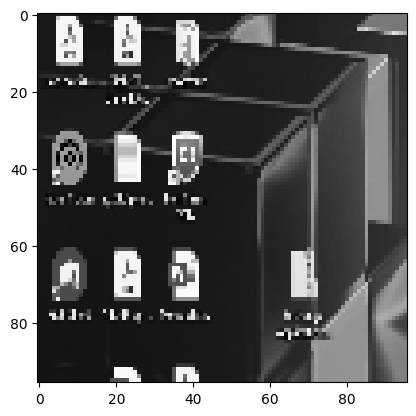

In [4]:
### Do screen grab and preprocess (make sure runner and some distance ahead is visible)

# Get screen grab and drop alpha channel
game_img = screen.grab(GAME_CROP)
game_img = np.array(game_img)[:, :, :3]

# Convert to grayscale and resize
game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))

# Add channel dimension last (to mimic Gymnasium's examples)
game_img = np.reshape(game_img, (GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))

# Show crop/resized
print(f"Shape: {game_img.shape}")
print(f"Example row: {game_img[0, :]}")
plt.imshow(game_img, cmap='gray', vmin=0, vmax=255)

# Try showing image in new window
if DISP_SCALE_FACTOR > 0:
    disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
    disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
    disp_img = cv2.resize(game_img, (disp_width, disp_height), interpolation=cv2.INTER_AREA)
    cv2.namedWindow('Game Image')
    cv2.imshow('Game Image', disp_img)
    cv2.waitKey(2000)
    cv2.destroyAllWindows()

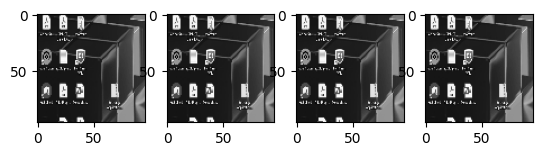

In [5]:
### Try frame stacking

# Simple frame grab, crop, and resize
def screen_grab_test():

    # Get screen grab and drop alpha channel
    game_img = screen.grab(GAME_CROP)
    game_img = np.array(game_img)[:, :, :3]

    # Convert to grayscale and resize
    game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
    game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))

    # Add channel dimension last (to mimic Gymnasium's examples)
    game_img = np.reshape(game_img, (GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
    
    return game_img

# Capture a full stack of frames
frame_stack = np.zeros((GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE))
for _ in range(GAME_FRAME_STACK_SIZE):

    # Roll frame stack and add new frame to the end
    img = screen_grab_test()
    frame_stack = np.roll(frame_stack, -1, axis=-1)
    frame_stack[:, :, -1] = img
    
    # Wait between frame captures
    time.sleep(1.0)
    
# Show frames
fig, axs = plt.subplots(1, GAME_FRAME_STACK_SIZE)
for i in range(GAME_FRAME_STACK_SIZE):
    axs[i].imshow(frame_stack[:, :, i], cmap='gray', vmin=0, vmax=255)

In [6]:
### Use scaled game image to find head height

# Print a few rows to see values
# print(game_img[0, HEAD_ROW_MIN:HEAD_ROW_MAX, :])

# Find dark pixels between two rows where the head likely is
locs = np.where(frame_stack[-1, HEAD_ROW_MIN:HEAD_ROW_MAX, :] < HEAD_PIXEL_THRESHOLD)
rows = np.sort(locs[0]) + HEAD_ROW_MIN
print(f"Pixels below color threshold: " 
          f"{locs}")
print(f"Rows must be offset: {locs[0] + HEAD_ROW_MIN}")

# Give row of first dark pixel in likely head range
if rows.size > 0:
    print(f"Head at row {rows[0]}")
else:
    print(f"No head detected")

Pixels below color threshold: (array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
       17, 17, 17, 17, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 29,
       29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33,
       33, 33, 41, 41, 41, 41, 42, 42, 42, 42, 43, 43, 43, 43, 44, 44, 44,
       44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47, 48, 48, 48, 48,
       49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 52, 53,
       53, 53, 53, 55, 55, 55, 55], dtype=int64), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1,
       2, 3, 0, 1, 2, 3, 

In [7]:
### Create OCR context
timestamp = time.time()
ocr_api = tesserocr.PyTessBaseAPI()
print(f"Context setup: {(time.time() - timestamp):.5f} sec")

Context setup: 0.05001 sec


Screen grab: 0.00900 sec
Prep image: 0.00100 sec
OCR: 0.00400 sec
Total: 0.01400 sec
OCR string: 
Score: 0.0


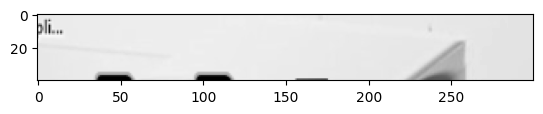

In [8]:
### Use OCR to get score

total_time = 0.0

# Get screen grab and drop alpha channel
timestamp = time.time()
score_img = screen.grab(SCORE_CROP)
score_img = np.array(score_img)[:, :, :3]
section_time = time.time() - timestamp
total_time += section_time
print(f"Screen grab: {section_time:.5f} sec")

# Smaller, grayscale image with dark text on light background makes for fast OCR
timestamp = time.time()
score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2GRAY)
score_img = cv2.resize(score_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
score_img = 255 - score_img
pil_img = Image.fromarray(score_img)
section_time = time.time() - timestamp
total_time += section_time
print(f"Prep image: {section_time:.5f} sec")

# Use tesserocr to get text from image
ocr_str = ""
timestamp = time.time()
try:
    ocr_api.SetImage(pil_img)
    ocr_str = ocr_api.GetUTF8Text()
except:
    print("ERROR: Could not perform OCR")
    
# Display timing
section_time = time.time() - timestamp
total_time += section_time
print(f"OCR: {section_time:.5f} sec")
print(f"Total: {total_time:.5f} sec")

# Display OCR results
score = 0.0
if ocr_str:
    score_str = ocr_str.split()[0]
    try:
        score = float(float(score_str))
    except ValueError:
        pass
print(f"OCR string: {ocr_str}")
print(f"Score: {score}")

# Show image
plt.imshow(score_img, cmap='gray')

Screen grab: 0.01100 sec
Prep image: 0.00000 sec
OCR: 0.00100 sec
Total: 0.01200 sec
OCR string: 
Done: False


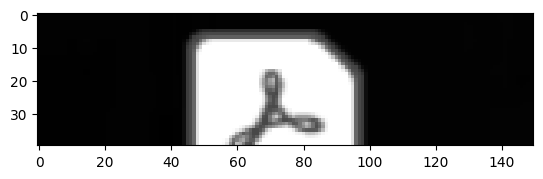

In [9]:
### Use OCR to get done screen

total_time = 0.0

# Get screen grab and drop alpha channel
timestamp = time.time()
done_img = screen.grab(DONE_CROP)
done_img = np.array(done_img)[:, :, :3]
section_time = time.time() - timestamp
total_time += section_time
print(f"Screen grab: {section_time:.5f} sec")

# Smaller, grayscale image with dark text on light background makes for fast OCR
timestamp = time.time()
done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2GRAY)
done_img = cv2.resize(done_img, (DONE_RESIZE_WIDTH, DONE_RESIZE_HEIGHT))
pil_img = Image.fromarray(done_img)
section_time = time.time() - timestamp
total_time += section_time
print(f"Prep image: {section_time:.5f} sec")

# Use tesserocr to get text from image
ocr_str = ""
timestamp = time.time()
try:
    ocr_api.SetImage(pil_img)
    ocr_str = ocr_api.GetUTF8Text()
except:
    print("ERROR: Could not perform OCR")
    
# Display timing
section_time = time.time() - timestamp
total_time += section_time
print(f"OCR: {section_time:.5f} sec")
print(f"Total: {total_time:.5f} sec")

# Display OCR results
done = False
ocr_str = ocr_str.strip()
if ocr_str:
    done_str = ocr_str.split()[0].lower()
    if done_str in GAME_OVER_STRINGS:
        done = True
print(f"OCR string: {ocr_str}")
print(f"Done: {done}")

# Show image
plt.imshow(done_img, cmap='gray')

In [10]:
### End OCR context
ocr_api.End()

## Test Spaces

The gymnasium Environment (Env) requires us to define the observation space and action space so it can know what kinds of data to expect when it interacts with the environment. For us, the observation space is the shape and bit width of the normalized, scaled screen capture (our runner and some space in front of them). The action space is all the available actions we can input into the game (q, w, o, p) along with doing nothing (no-op). We should also test the ability to restart the game (pressing space bar). As with the screen capture actions, these actions will be incorporated into the custom Env.

In [11]:
### Test observation space

# Create an observation space
observation_space = gym.spaces.Box(low=0,
                                   high=255,
                                   shape=(GAME_RESIZE_WIDTH, GAME_RESIZE_WIDTH),
                                   dtype=DTYPE)

# Randomly sample from it to show that it matches our expected input screen capture
obs = observation_space.sample()
print(f"Shape: {obs.shape}")
print(f"Example row: {obs[0, :]}")

Shape: (96, 96)
Example row: [ 18 252 191 155 247 155   3  48 178 244 218  63   7 116 131 247  46 148
 168 210  49 171 182 141 247  83  13 102 186 235  31 192  79  78  37 226
 101   9 141  90 208 109  10 104 192  71  22 155 128 218 183 209  48 195
 186  81  93  69 188 171 207 226 247  66  64  66 166 222  78 178   1  23
 229 118 222   9  45  64 133 132 209 102 184  62 133 193  70  42 248 199
 140  37  29  71  33 170]


In [12]:
### Test action space

# Create an action space
action_space = gym.spaces.Discrete(len(ACTIONS_MAP))

# Sample from it to show that we can randomly generate a number corresponding to an action
action = action_space.sample()
print(f"{action}: {ACTIONS_MAP[action]}")

0: no-op


In [13]:
### Test control interaction: reset game and do some random stuff

# Create interaction objects
keyboard = pynput.keyboard.Controller()
mouse = pynput.mouse.Controller()

# Move mouse to QWOP window and click to bring to focus
time.sleep(2)
mouse.position = RESTART_MOUSE_POS
time.sleep(1)
mouse.press(pynput.mouse.Button.left)
mouse.release(pynput.mouse.Button.left)

# Press 'r' to restart game
keyboard.press(RESTART_KEY)
keyboard.release(RESTART_KEY)

# Sample randomly from our action space to control the game
for _ in range(10):
    
    # Release everything
    keyboard.release('q')
    keyboard.release('w')
    keyboard.release('o')
    keyboard.release('p')
    
    # Try pressing one of the key combos
    action = action_space.sample()
    if ACTIONS_MAP[action] == 'press q':
        keyboard.press('q')
    elif ACTIONS_MAP[action] == 'press w':
        keyboard.press('w')
    elif ACTIONS_MAP[action] == 'press qp':
        keyboard.press('o')
    elif ACTIONS_MAP[action] == 'press wo':
        keyboard.press('p')
    print(f"{ACTIONS_MAP[action]}: {action}")
    time.sleep(ACTIONS_KEY_PRESS_TIME)
    

press wo: 4
no-op: 0
no-op: 0
press q: 1
no-op: 0
press w: 2
press q: 1
press q: 1
press qp: 3
no-op: 0


## Build gym Environment

Subclass gymnasium.Env to create a custom environment. Learn more here: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/

In [14]:
class WebGame(gym.Env):
    """
    Subclass gymnasium Env class
    
    This is the gym wrapper class that allows our agent to interact with our environment. We need
    to implement four main methods: step(), reset(), render(), and close(). We should also define
    the action_space and observation space as class members.
    
    Note: on Windows, time.sleep() is only accurate to around 10ms. As a result, setting fps_limit
    will give you a "best effort" limit.
    
    More information: https://gymnasium.farama.org/api/env/
    """
    
    # Set up the environment, action, and observation shapes. Optional timeout in seconds.
    def __init__(self, 
                 timeout=0.0, 
                 disp_scale=0.0, 
                 fps_limit=0.0, 
                 show_fps=False, 
                 debug_time=False):
        
        # Call superclass's constructor
        super().__init__()
        
        # Env requires us to define the action space
        self.action_space = gym.spaces.Discrete(len(ACTIONS_MAP))
        
        # Env requires us to define the observation space
        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE),
            dtype=DTYPE
        )
        
        # Screen capture object
        self.screen = mss()
        
        # OCR context
        self.ocr_api = tesserocr.PyTessBaseAPI()
        
        # Interaction objects
        self.keyboard = pynput.keyboard.Controller()
        self.mouse = pynput.mouse.Controller()
        
        # Record total score between rounds (to calculate reward each step)
        self.score = 0.0
        
        # States for rewarding actions
        self.prev_action = 0
        self.action_timestamp = time.time()
        self.action_reward_received = False
        
        # Used to record the time
        self.timeout = timeout
        self.start_time = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
            
        # How much to scale the render window
        self.disp_scale = disp_scale
        
        # Limit the FPS for consistency
        self.fps_limit = fps_limit
        
        # Record time for debugging and showing FPS in render window
        self.fps = 0.0
        self.avg_fps_array = [0.0] * FPS_AVG_LEN
        self.show_fps = show_fps
        self.timestamp = time.time()
        self.debug_time = debug_time
        self.debug_start_time = time.time()
        self.debug_timestamp = time.time()

        # Initialize game frame stack
        self.frame_stack = np.zeros((GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH, GAME_FRAME_STACK_SIZE), dtype=DTYPE)
        
        # Show rendering in new window if requested
        if self.disp_scale > 0.0:
            cv2.namedWindow('Game Image')
        
        pass
    
    # What happens when you take a step in the game (e.g. each frame)
    def step(self, action):
        
        # Debug timing
        self._show_debug_time("Step start")
        
        # Set initial reward
        reward = 0
        
        # Release all keys
        keyboard.release('q')
        keyboard.release('w')
        keyboard.release('o')
        keyboard.release('p')
        
        # Perform action (don't do anything for no-op)
        if ACTIONS_MAP[action] == 'press q':
            self.keyboard.press('q')
        elif ACTIONS_MAP[action] == 'press w':
            self.keyboard.press('w')
        elif ACTIONS_MAP[action] == 'press qp':
            self.keyboard.press('q')
            self.keyboard.press('p')
        elif ACTIONS_MAP[action] == 'press wo':
            self.keyboard.press('w')
            self.keyboard.press('o')
        self._show_debug_time("Perform action")
        
        # Reward agent for holding the same key(s) for a while to encourage leg switching
        now = time.time()
        if action == self.prev_action:
            if (now - self.action_timestamp >= LONG_PRESS_THRESHOLD and 
                    not self.action_reward_received):
                
                # Enforce switching between 'qp' and 'wo'
                if ACTIONS_MAP[action] == 'press qp' and self.prev_key_combo == "wo":
                    reward += LONG_PRESS_REWARD
                    self.prev_key_combo = "qp"
                    print(f"Keys held: {ACTIONS_MAP[action]} for reward: {reward}")
                if ACTIONS_MAP[action] == 'press wo' and self.prev_key_combo == "qp":
                    reward += LONG_PRESS_REWARD
                    self.prev_key_combo = "wo"
                    print(f"Keys held: {ACTIONS_MAP[action]} for reward: {reward}")
                    
                # Prevent recurring rewards for same key press
                self.action_reward_received = True
        
        if action == self.prev_action:
            if (now - self.action_timestamp >= LONG_PRESS_THRESHOLD and 
                    not self.action_reward_received):
                reward += LONG_PRESS_REWARD
                self.action_reward_received = True
                print(f"Keys held: {reward}")
        else:
            self.action_timestamp = time.time()
            self.action_reward_received = False
        self.prev_action = action
        
            
        # Get next observation, render, and add to frame stack
        frame_stack = self.get_observation()
        self._show_debug_time("Get obs")
        
        # Use distance as reward score. Calculate score difference between this step and previous.
        prev_score = self.score
        self.score = self.get_score()
        reward += SCORE_MULTIPLIER * (self.score - prev_score)
        self._show_debug_time("Get score")
        
        # See if we ran the distance set by the goal
        if self.score >= GOAL_MARKER:
            reward += GOAL_REWARD
            terminated = True
            
        # Check if done, penalize agent for falling
        else:
            terminated = self.get_done()
            self._show_debug_time("Get done")
            if terminated:
                reward += FALL_REWARD
        
        # Penalize agent for letting head drop below a given row to discourage "scooting"
        head_row = self.get_head_row(frame_stack[-1])
        if head_row > HEAD_HEIGHT_THRESHOLD:
            reward += KNEEL_REWARD
        self._show_debug_time("Get head row")
        
        # Check if we've exceeded the time limit
        elapsed_time = 0.0
        truncated = False
        if not terminated and self.timeout > 0.0:
            elapsed_time = time.time() - self.start_time
            if elapsed_time >= self.timeout:
                truncated = True
                
        # Release all control keys if ending
        if terminated or truncated:
            self.keyboard.release('q')
            self.keyboard.release('w')
            self.keyboard.release('o')
            self.keyboard.release('p')
            
        # Wait if needed to meet FPS limit
        now = time.time()
        if self.fps_limit > 0.0:
            to_wait = (1 / self.fps_limit) - (now - self.timestamp)
            if to_wait > 0:
                time.sleep(to_wait)
            
        # Calculate FPS and slide average FPS window
        now = time.time()
        self.fps = 1 / (now - self.timestamp)
        self.avg_fps_array = self.avg_fps_array[1:]
        self.avg_fps_array.append(self.fps)
        self.timestamp = now
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': elapsed_time, 'fps': self.fps}
        
        # Done debugging time
        self._show_debug_time("Final checks")
        if self.debug_time:
            print("---")

        return frame_stack, reward, terminated, truncated, info
    
    # Visualize the game using OpenCV
    def render(self, img, track_head=False):
        if self.disp_scale > 0:
            
            # Draw tracking marker for head and threshold row
            if track_head:
                head_row = self.get_head_row(img)
                head_col = int(img.shape[1] / 2)
                img[head_row, head_col] = 255
                img[HEAD_HEIGHT_THRESHOLD, ::3] = 255
            
            # Resize our game image to something that can be easily seen
            disp_width = int(GAME_RESIZE_WIDTH * DISP_SCALE_FACTOR)
            disp_height = int(GAME_RESIZE_HEIGHT * DISP_SCALE_FACTOR)
            disp_img = cv2.resize(img, (disp_width, disp_height), interpolation=cv2.INTER_AREA)
            
            # Add FPS counter to image
            if self.show_fps:
                fps = self.get_avg_fps()
                disp_img = cv2.putText(disp_img, 
                                       f"fps: {fps:.1f}", 
                                       (10, 25), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 
                                       1, 
                                       (255), 
                                       2, 
                                       cv2.LINE_AA)
                

                
            # Draw and wait 1 ms
            cv2.imshow('Game Image', disp_img)
            cv2.waitKey(1)
    
    # Restart the game
    def reset(self):
        
        # Wait, move mouse to game window, click for focus
        time.sleep(0.5)
        self.mouse.position = RESTART_MOUSE_POS
        self.mouse.press(pynput.mouse.Button.left)
        self.mouse.release(pynput.mouse.Button.left)
        
        # Press 'r' to restart game
        self.keyboard.press(RESTART_KEY)
        time.sleep(ACTIONS_KEY_PRESS_TIME)
        self.keyboard.release(RESTART_KEY)
        
        # Reset score and time
        self.score = 0.0
        if self.timeout > 0.0:
            self.start_time = time.time()
            
        # States for rewarding actions
        self.prev_action = 0
        self.action_timestamp = time.time()
        self.action_reward_received = False
        self.prev_key_combo = "wo"
        
        # Let the game restart before getting the first observation
        time.sleep(0.3)
        
        # Reinitialize frame stack and get first observation of new game
        self.frame_stack[:, :, :] = 0
        frame_stack = self.get_observation()
        
        # Return auxiliary information for debugging
        info = {'score': self.score, 'time': 0.0, 'fps': 0.0}
        
        return frame_stack, info
    
    # Close down the game: release keys, close OpenCV windows, end OCR context
    def close(self):
        self.keyboard.release('q')
        self.keyboard.release('w')
        self.keyboard.release('o')
        self.keyboard.release('p')
        cv2.destroyAllWindows()
        ocr_api.End()
    
    # Get the part of the observation of the game that we want (e.g. crop, resize)
    def get_observation(self):
        
        # Get screen grab and drop alpha channel
        game_img = screen.grab(GAME_CROP)
        game_img = np.array(game_img, dtype=DTYPE)[:, :, :3]

        # Convert to grayscale and resize
        game_img = cv2.cvtColor(game_img, cv2.COLOR_BGR2GRAY)
        game_img = cv2.resize(game_img, (GAME_RESIZE_WIDTH, GAME_RESIZE_HEIGHT))
        
        # Add channel dimension first (in case you want RGB later)
        game_img = np.reshape(game_img, (GAME_RESIZE_HEIGHT, GAME_RESIZE_WIDTH))
        
        # Roll frame stack and add image to the end
        self.frame_stack = np.roll(self.frame_stack, -1, axis=-1)
        self.frame_stack[:, :, -1] = game_img
        
        # Render
        self.render(game_img, track_head=True)
        
        return self.frame_stack
    
    # Get the distance ran to use as a total score and to calculate rewards
    def get_score(self):
        
        # Get screen grab and drop alpha channel
        score_img = screen.grab(SCORE_CROP)
        score_img = np.array(score_img)[:, :, :3]

        # Resize, convert to grayscale, invert for fast OCR
        score_img = cv2.cvtColor(score_img, cv2.COLOR_BGR2GRAY)
        score_img = cv2.resize(score_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
        score_img = 255 - score_img
        pil_img = Image.fromarray(score_img)

        # Do OCR
        ocr_str = ""
        try:
            self.ocr_api.SetImage(pil_img)
            ocr_str = self.ocr_api.GetUTF8Text()
        except:
            print("ERROR: Could not perform OCR")
        
        # Extract score as a number
        score = 0.0
        ocr_str = ocr_str.strip()
        if ocr_str:
            score_str = ocr_str.split()[0]
            try:
                score = float(float(score_str))
            except ValueError:
                pass
        
        return score
    
    # Get the row of the head
    def get_head_row(self, img):
        
        # Give row of first dark pixel in likely head range
        locs = np.where(img[HEAD_ROW_MIN:HEAD_ROW_MAX, :] < HEAD_PIXEL_THRESHOLD)
        rows = np.sort(locs[0]) + HEAD_ROW_MIN
        if rows.size > 0:
            return rows[0]
        else:
            return -1
    
    # Get the done text using OCR
    def get_done(self):
        
        # Get screen grab and drop alpha channel
        done_img = screen.grab(DONE_CROP)
        done_img = np.array(done_img)[:, :, :3]
        
        # Resize, convert to grayscale, invert for fast OCR
        done_img = cv2.cvtColor(done_img, cv2.COLOR_BGR2GRAY)
        done_img = cv2.resize(done_img, (SCORE_RESIZE_WIDTH, SCORE_RESIZE_HEIGHT))
        pil_img = Image.fromarray(done_img)
        
        # Do OCR
        ocr_str = ""
        try:
            self.ocr_api.SetImage(pil_img)
            ocr_str = self.ocr_api.GetUTF8Text()
        except:
            print("ERROR: Could not perform OCR")

        # Extract done state as a boolean
        done = False
        ocr_str = ocr_str.strip()
        if ocr_str:
            done_str = ocr_str.split()[0].lower()
            if done_str in GAME_OVER_STRINGS:
                done = True
                
        return done
    
    # Get average FPS
    def get_avg_fps(self):
        return sum(self.avg_fps_array) / len(self.avg_fps_array)
    
    # Report time elapsed from environment start and time elapsed from last call
    def _show_debug_time(self, msg=""):
        if self.debug_time:
            debug_now = time.time()
            print(f"Timestamp: {(debug_now - self.debug_start_time):.2f} | "
                  f"Since last: {(debug_now - self.debug_timestamp):.2f} | "
                  f"{msg}")
            self.debug_timestamp = debug_now

## Test gym Environment

It's always a good idea to test your environment wrapper before training.

In [15]:
# Create our environment with a timeout
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=5.0, 
              disp_scale=2.0, 
              fps_limit=18,
              show_fps=True, 
              debug_time=False)

Score: 0.0
Done: False
Shape: (96, 96, 4)


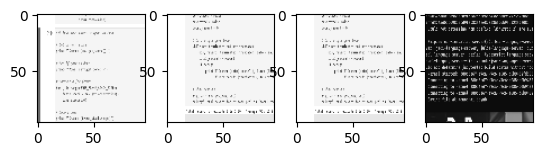

In [23]:
### Test environment wrapper methods

# Get current score
print(f"Score: {env.get_score()}")

# See if game is done
print(f"Done: {env.get_done()}")

# Capture a few frames
for _ in range(GAME_FRAME_STACK_SIZE):
    frame_stack = env.get_observation()
    time.sleep(1.0)

# Show frames
print(f"Shape: {frame_stack.shape}")
fig, axs = plt.subplots(1, GAME_FRAME_STACK_SIZE)
for i in range(GAME_FRAME_STACK_SIZE):
    axs[i].imshow(frame_stack[:, :, i], cmap='gray', vmin=0, vmax=255)

In [ ]:
### Test game loop

debug = False

# Do a few game loops
for ep in range(3):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    
    # Do a single game loop
    while not terminated and not truncated:
        obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
        if debug:
            print(f"Score: {info['score']}, Time: {info['time']}, FPS: {info['fps']}, "
                  f"Terminated: {terminated}, Truncated: {truncated}")
        
    # Show results
    avg_fps = env.get_avg_fps()
    print(f"Total reward for episode {ep} is {total_reward:.2f} | Average FPS: {avg_fps:.1f}")

In [164]:
# Test if game runs while lid is closed
# Should receive consistent ~ -1 m scores

time.sleep(2.0)

num_tests = 5
for ep in range(num_tests):
    
    # Initialize game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    action = 4  # Press 'wo'
    
    # Do a single game loop
    while not terminated and not truncated:
        
        # Hold 'o' to fall forward
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        if debug:
            print(f"Score: {info['score']}, Time: {info['time']}, "
                  f"Terminated: {terminated}, Truncated: {truncated}")
    # Show results
    avg_fps = env.get_avg_fps()
    print(f"Total reward for episode {ep} is {total_reward:.2f} | Average FPS: {avg_fps:.1f}")

Total reward for episode 0 is 0.00 | Average FPS: 16.1
Total reward for episode 1 is 0.00 | Average FPS: 16.0
Total reward for episode 2 is 0.00 | Average FPS: 16.0
Total reward for episode 3 is 0.00 | Average FPS: 16.0
Total reward for episode 4 is 0.00 | Average FPS: 16.1


In [18]:
# Final environment check to make sure it works with Stable-Baselines3
env_checker.check_env(env)

In [17]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3070'

## Checkpoint callback

We'll create a custom callback for Stable Baselines3 that saves the model every n steps. This helps us recover from an error, disconnect, or power loss.

In [16]:
class SaveCheckpointCallback(BaseCallback):
    """
    Save the model every ``check_freq`` steps
    
    More information: https://stable-baselines3.readthedocs.io/en/master/guide/callbacks.html
    """
    
    # Constructor
    def __init__(self, check_freq, save_dir, verbose=1):
        super(SaveCheckpointCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_dir = save_dir
        
    # Create directory for saving the models
    def _init_callback(self):
        if self.save_dir is not None:
            os.makedirs(self.save_dir, exist_ok=True)
            
    # Save model every check_freq steps
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_dir, f"model_{self.n_calls}")
            self.model.save(model_path)
        return True

In [17]:
# Set up checkpoint callback
checkpoint_callback = SaveCheckpointCallback(
    check_freq=CHECKPOINT_FREQ, 
    save_dir=CHECKPOINT_DIR,
    verbose=1
)

## Custom logger

I'm going to use Weights & Biases for logging so I can view the training progress remotely. See the [Logger documentation](https://stable-baselines3.readthedocs.io/en/master/common/logger.html) and [integration examples](https://github.com/DLR-RM/stable-baselines3/blob/master/docs/guide/integrations.rst) for how to create a custom writer.

Feel free to use a different method for logging, such as TensorBoard. See [here](https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html) for how to set up TensorBoard.

In [18]:
class WandBWriter(KVWriter):
    """
    Log metrics to Weights & Biases when called by .learn()
    
    More info: https://stable-baselines3.readthedocs.io/en/master/_modules/stable_baselines3/common/logger.html#KVWriter
    """
    
    # Initialize run
    def __init__(self, run, verbose=1):
        super().__init__()
        self.run = run
        self.verbose = verbose

    # Write metrics to W&B project
    def write(self, 
              key_values: Dict[str, Any], 
              key_excluded: Dict[str, Union[str, Tuple[str, ...]]], 
              step: int = 0) -> None:
        log_dict = {}
        
        # Go through each key/value pairs
        for (key, value), (_, excluded) in zip(
            sorted(key_values.items()), sorted(key_excluded.items())):
            
            if self.verbose >= 2:
                print(f"step={step} | {key} : {value} ({type(value)})")
            
            # Skip excluded items
            if excluded is not None and "wandb" in excluded:
                continue
                
            # Log integers and floats
            if isinstance(value, np.ScalarType):
                if not isinstance(value, str):
                    wandb.log(data={key: value}, step=step)
                    log_dict[key] = value
                
        # Print to console
        if self.verbose >= 1:
            print(f"Log for steps={step}")
            print(f"--------------")
            for (key, value) in sorted(log_dict.items()):
                print(f"  {key}: {value}")
            print()
                
    # Close the W&B run
    def close(self) -> None:
        self.run.finish()

In [19]:
# Log in to Weights & Biases
wandb.login()

wandb: Currently logged in as: ishaan-vyas2000 (team-name-carefully). Use `wandb login --relogin` to force relogin


True

In [20]:
# Create new W&B run
config = {}
dt = datetime.datetime.now(datetime.timezone.utc)
dt = dt.replace(microsecond=0, tzinfo=None)
run = wandb.init(project=WANDB_PROJECT, name=str(dt), config=config)

# Print run info
print(f"WandB run ID: {run.id}")
print(f"WandB run name: {run.name}") 

WandB run ID: abtj6uoz
WandB run name: 2023-11-09 15:15:08


In [21]:
# Set custom logger with our custom writer
wandb_writer = WandBWriter(run, verbose=0)
loggers = Logger(
    folder=None,
    output_formats=[wandb_writer]
)

## Train Model

In [22]:
# Hyperparameters
hparams = {
    "episode_timeout": 120,              # 30 sec episode timeout
    "fps_limit": 18,                    # Is actually ~15 fps on Windows
    "learning_rate": 0.0001,            # Default is 0.0003
    "steps_per_update": 512,            # Default is 2048
    "entropy_coefficient": 0.001,         # Higher entropy encourages more exploration. Default is 0
    "total_timesteps": 300_000,         # At 15 fps is about 2 hours
    "num_actions": len(ACTIONS_MAP),
    "model_name": "qwop_model_v09",
    "notes": "Reward switching long presses of wo and qp"
}

# Log hyperparameters to W&B
wandb.config.update(hparams)

In [23]:
# Create our environment with a timeout for training
try:
    env.close()
except NameError:
    pass
env = WebGame(timeout=hparams["episode_timeout"],
              disp_scale=DISP_SCALE_FACTOR,
              fps_limit=hparams["fps_limit"],
              show_fps=True)

In [25]:
from typing import Any, Dict, List, Optional, Type

import torch as th
from gymnasium import spaces
from torch import nn

from stable_baselines3.common.policies import BasePolicy
from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    NatureCNN,
    create_mlp,
)
from stable_baselines3.common.type_aliases import Schedule


class QNetwork(BasePolicy):
    """
    Action-Value (Q-Value) network for DQN

    :param observation_space: Observation space
    :param action_space: Action space
    :param net_arch: The specification of the policy and value networks.
    :param activation_fn: Activation function
    :param normalize_images: Whether to normalize images or not,
         dividing by 255.0 (True by default)
    """

    action_space: spaces.Discrete

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Discrete,
        features_extractor: BaseFeaturesExtractor,
        features_dim: int,
        net_arch: Optional[List[int]] = None,
        activation_fn: Type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
    ) -> None:
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        if net_arch is None:
            net_arch = [64, 64]

        self.net_arch = net_arch
        self.activation_fn = activation_fn
        self.features_dim = features_dim
        action_dim = int(self.action_space.n)  # number of actions
        q_net = create_mlp(self.features_dim, action_dim, self.net_arch, self.activation_fn)
        ac_net = create_mlp(self.features_dim, action_dim, self.net_arch, self.activation_fn)
        self.q_net = nn.Sequential(*q_net)
        self.ac_net = nn.Sequential(*ac_net)

    def forward(self, obs: th.Tensor) -> th.Tensor:
        """
        Predict the q-values.

        :param obs: Observation
        :return: The estimated Q-Value for each action.
        """
        extracted_features = self.extract_features(obs, self.features_extractor)
        state_value = self.q_net(extracted_features)
        action_value = self.ac_net(extracted_features)
        action_score_centered = action_value - action_value.mean(dim=-1, keepdim=True)
        return state_value + action_score_centered

    def _predict(self, observation: th.Tensor, deterministic: bool = True) -> th.Tensor:
        q_values = self(observation)
        # Greedy action
        action = q_values.argmax(dim=1).reshape(-1)
        return action

    def _get_constructor_parameters(self) -> Dict[str, Any]:
        data = super()._get_constructor_parameters()

        data.update(
            dict(
                net_arch=self.net_arch,
                features_dim=self.features_dim,
                activation_fn=self.activation_fn,
                features_extractor=self.features_extractor,
            )
        )
        return data


class DQNPolicy(BasePolicy):
    """
    Policy class with Q-Value Net and target net for DQN

    :param observation_space: Observation space
    :param action_space: Action space
    :param lr_schedule: Learning rate schedule (could be constant)
    :param net_arch: The specification of the policy and value networks.
    :param activation_fn: Activation function
    :param features_extractor_class: Features extractor to use.
    :param features_extractor_kwargs: Keyword arguments
        to pass to the features extractor.
    :param normalize_images: Whether to normalize images or not,
         dividing by 255.0 (True by default)
    :param optimizer_class: The optimizer to use,
        ``th.optim.Adam`` by default
    :param optimizer_kwargs: Additional keyword arguments,
        excluding the learning rate, to pass to the optimizer
    """

    q_net: QNetwork
    q_net_target: QNetwork

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Discrete,
        lr_schedule: Schedule,
        net_arch: Optional[List[int]] = None,
        activation_fn: Type[nn.Module] = nn.ReLU,
        features_extractor_class: Type[BaseFeaturesExtractor] = FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
    ) -> None:
        super().__init__(
            observation_space,
            action_space,
            features_extractor_class,
            features_extractor_kwargs,
            optimizer_class=optimizer_class,
            optimizer_kwargs=optimizer_kwargs,
            normalize_images=normalize_images,
        )

        if net_arch is None:
            if features_extractor_class == NatureCNN:
                net_arch = []
            else:
                net_arch = [64, 64]

        self.net_arch = net_arch
        self.activation_fn = activation_fn

        self.net_args = {
            "observation_space": self.observation_space,
            "action_space": self.action_space,
            "net_arch": self.net_arch,
            "activation_fn": self.activation_fn,
            "normalize_images": normalize_images,
        }

        self._build(lr_schedule)

    def _build(self, lr_schedule: Schedule) -> None:
        """
        Create the network and the optimizer.

        Put the target network into evaluation mode.

        :param lr_schedule: Learning rate schedule
            lr_schedule(1) is the initial learning rate
        """

        self.q_net = self.make_q_net()
        self.q_net_target = self.make_q_net()
        self.q_net_target.load_state_dict(self.q_net.state_dict())
        self.q_net_target.set_training_mode(False)

        # Setup optimizer with initial learning rate
        self.optimizer = self.optimizer_class(  # type: ignore[call-arg]
            self.parameters(),
            lr=lr_schedule(1),
            **self.optimizer_kwargs,
        )

    def make_q_net(self) -> QNetwork:
        # Make sure we always have separate networks for features extractors etc
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return QNetwork(**net_args).to(self.device)

    def forward(self, obs: th.Tensor, deterministic: bool = True) -> th.Tensor:
        return self._predict(obs, deterministic=deterministic)

    def _predict(self, obs: th.Tensor, deterministic: bool = True) -> th.Tensor:
        return self.q_net._predict(obs, deterministic=deterministic)

    def _get_constructor_parameters(self) -> Dict[str, Any]:
        data = super()._get_constructor_parameters()

        data.update(
            dict(
                net_arch=self.net_args["net_arch"],
                activation_fn=self.net_args["activation_fn"],
                lr_schedule=self._dummy_schedule,  # dummy lr schedule, not needed for loading policy alone
                optimizer_class=self.optimizer_class,
                optimizer_kwargs=self.optimizer_kwargs,
                features_extractor_class=self.features_extractor_class,
                features_extractor_kwargs=self.features_extractor_kwargs,
            )
        )
        return data

    def set_training_mode(self, mode: bool) -> None:
        """
        Put the policy in either training or evaluation mode.

        This affects certain modules, such as batch normalisation and dropout.

        :param mode: if true, set to training mode, else set to evaluation mode
        """
        self.q_net.set_training_mode(mode)
        self.training = mode


MlpPolicy = DQNPolicy


class RainbowCnnPolicy(DQNPolicy):
    """
    Policy class for DQN when using images as input.

    :param observation_space: Observation space
    :param action_space: Action space
    :param lr_schedule: Learning rate schedule (could be constant)
    :param net_arch: The specification of the policy and value networks.
    :param activation_fn: Activation function
    :param features_extractor_class: Features extractor to use.
    :param normalize_images: Whether to normalize images or not,
         dividing by 255.0 (True by default)
    :param optimizer_class: The optimizer to use,
        ``th.optim.Adam`` by default
    :param optimizer_kwargs: Additional keyword arguments,
        excluding the learning rate, to pass to the optimizer
    """

    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Discrete,
        lr_schedule: Schedule,
        net_arch: Optional[List[int]] = None,
        activation_fn: Type[nn.Module] = nn.ReLU,
        features_extractor_class: Type[BaseFeaturesExtractor] = NatureCNN,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
    ) -> None:
        super().__init__(
            observation_space,
            action_space,
            lr_schedule,
            net_arch,
            activation_fn,
            features_extractor_class,
            features_extractor_kwargs,
            normalize_images,
            optimizer_class,
            optimizer_kwargs,
        )


In [24]:
# from torch.nn import functional as F
# #import torch as th

# from stable_baselines3.dqn.policies import CnnPolicy
# from stable_baselines3.common.utils import get_linear_fn

# # Credit for Double DQN https://github.com/DLR-RM/stable-baselines3/issues/487


# class RainbowDQN(DQN):
#     def train(self, gradient_steps: int, batch_size: int = 100) -> None:
#         # Switch to train mode (this affects batch norm / dropout)
#         self.policy.set_training_mode(True)
#         # Update learning rate according to schedule
#         self._update_learning_rate(self.policy.optimizer)

#         self.beta_schedule = get_linear_fn(
#             0.4,
#             1.0,
#             1.0,
#         )

#         losses = []
#         for _ in range(gradient_steps):
#             # Sample replay buffer
#             replay_data, weights, batch_idxes = self.replay_buffer.sample(
#                 batch_size, beta=self.beta_schedule(self._current_progress_remaining), env=self._vec_normalize_env)  # type: ignore[union-attr]

#             with th.no_grad():
#                 # Compute the next Q-values using the target network
#                 next_q_values = self.q_net_target(
#                     replay_data.next_observations)
#                 # Follow greedy policy: use the one with the highest value
#                 next_q_values, _ = next_q_values.max(dim=1)
#                 # Avoid potential broadcast issue
#                 next_q_values = next_q_values.reshape(-1, 1)
#                 # 1-step TD target
#                 target_q_values = replay_data.rewards + \
#                     (1 - replay_data.dones) * self.gamma * next_q_values

#             # Get current Q-values estimates
#             current_q_values = self.q_net(replay_data.observations)

#             # Retrieve the q-values for the actions from the replay buffer
#             current_q_values = th.gather(
#                 current_q_values, dim=1, index=replay_data.actions.long())

#             # Compute Huber loss (less sensitive to outliers)
#             loss = F.smooth_l1_loss(current_q_values, target_q_values)
#             # prioritized replay
#             weights = th.from_numpy(weights).to('cuda:0')
#             loss = th.mean(weights * loss)
#             losses.append(loss.item())

#             # Optimize the policy
#             self.policy.optimizer.zero_grad()
#             loss.backward()
#             # Clip gradient norm
#             th.nn.utils.clip_grad_norm_(
#                 self.policy.parameters(), self.max_grad_norm)
#             self.policy.optimizer.step()

#             # prioritized replay
#             new_priorities = np.abs(
#                 target_q_values.cpu().detach().numpy() - current_q_values.cpu().detach().numpy()) + 1e-6
#             assert isinstance(self.replay_buffer, PrioritizedReplayBuffer)
#             self.replay_buffer.update_priorities(batch_idxes, new_priorities)

#         # Increase update counter
#         self._n_updates += gradient_steps

#         self.logger.record("train/n_updates",
#                            self._n_updates, exclude="tensorboard")
#         self.logger.record("train/loss", np.mean(losses))


In [25]:
# import numpy as np

# from stable_baselines3.common.buffers import ReplayBuffer


# def unique(sorted_array):
#     """
#     More efficient implementation of np.unique for sorted arrays
#     :param sorted_array: (np.ndarray)
#     :return:(np.ndarray) sorted_array without duplicate elements
#     """
#     if len(sorted_array) == 1:
#         return sorted_array
#     left = sorted_array[:-1]
#     right = sorted_array[1:]
#     uniques = np.append(right != left, True)
#     return sorted_array[uniques]


# class SegmentTree(object):
#     def __init__(self, capacity, operation, neutral_element):
#         """
#         Build a Segment Tree data structure.

#         https://en.wikipedia.org/wiki/Segment_tree

#         Can be used as regular array that supports Index arrays, but with two
#         important differences:

#             a) setting item's value is slightly slower.
#                It is O(lg capacity) instead of O(1).
#             b) user has access to an efficient ( O(log segment size) )
#                `reduce` operation which reduces `operation` over
#                a contiguous subsequence of items in the array.

#         :param capacity: (int) Total size of the array - must be a power of two.
#         :param operation: (lambda (Any, Any): Any) operation for combining elements (eg. sum, max) must form a
#             mathematical group together with the set of possible values for array elements (i.e. be associative)
#         :param neutral_element: (Any) neutral element for the operation above. eg. float('-inf') for max and 0 for sum.
#         """
#         assert capacity > 0 and capacity & (
#             capacity - 1) == 0, "capacity must be positive and a power of 2."
#         self._capacity = capacity
#         self._value = [neutral_element for _ in range(2 * capacity)]
#         self._operation = operation
#         self.neutral_element = neutral_element

#     def _reduce_helper(self, start, end, node, node_start, node_end):
#         if start == node_start and end == node_end:
#             return self._value[node]
#         mid = (node_start + node_end) // 2
#         if end <= mid:
#             return self._reduce_helper(start, end, 2 * node, node_start, mid)
#         else:
#             if mid + 1 <= start:
#                 return self._reduce_helper(start, end, 2 * node + 1, mid + 1, node_end)
#             else:
#                 return self._operation(
#                     self._reduce_helper(start, mid, 2 * node, node_start, mid),
#                     self._reduce_helper(
#                         mid + 1, end, 2 * node + 1, mid + 1, node_end)
#                 )

#     def reduce(self, start=0, end=None):
#         """
#         Returns result of applying `self.operation`
#         to a contiguous subsequence of the array.

#             self.operation(arr[start], operation(arr[start+1], operation(... arr[end])))

#         :param start: (int) beginning of the subsequence
#         :param end: (int) end of the subsequences
#         :return: (Any) result of reducing self.operation over the specified range of array elements.
#         """
#         if end is None:
#             end = self._capacity
#         if end < 0:
#             end += self._capacity
#         end -= 1
#         return self._reduce_helper(start, end, 1, 0, self._capacity - 1)

#     def __setitem__(self, idx, val):
#         # indexes of the leaf
#         idxs = idx + self._capacity
#         self._value[idxs] = val
#         if isinstance(idxs, int):
#             idxs = np.array([idxs])
#         # go up one level in the tree and remove duplicate indexes
#         idxs = unique(idxs // 2)
#         while len(idxs) > 1 or idxs[0] > 0:
#             # as long as there are non-zero indexes, update the corresponding values
#             self._value[idxs] = self._operation(
#                 self._value[2 * idxs],
#                 self._value[2 * idxs + 1]
#             )
#             # go up one level in the tree and remove duplicate indexes
#             idxs = unique(idxs // 2)

#     def __getitem__(self, idx):
#         assert np.max(idx) < self._capacity
#         assert 0 <= np.min(idx)
#         return self._value[self._capacity + idx]


# class SumSegmentTree(SegmentTree):
#     def __init__(self, capacity):
#         super(SumSegmentTree, self).__init__(
#             capacity=capacity,
#             operation=np.add,
#             neutral_element=0.0
#         )
#         self._value = np.array(self._value)

#     def sum(self, start=0, end=None):
#         """
#         Returns arr[start] + ... + arr[end]

#         :param start: (int) start position of the reduction (must be >= 0)
#         :param end: (int) end position of the reduction (must be < len(arr), can be None for len(arr) - 1)
#         :return: (Any) reduction of SumSegmentTree
#         """
#         return super(SumSegmentTree, self).reduce(start, end)

#     def find_prefixsum_idx(self, prefixsum):
#         """
#         Find the highest index `i` in the array such that
#             sum(arr[0] + arr[1] + ... + arr[i - i]) <= prefixsum for each entry in prefixsum

#         if array values are probabilities, this function
#         allows to sample indexes according to the discrete
#         probability efficiently.

#         :param prefixsum: (np.ndarray) float upper bounds on the sum of array prefix
#         :return: (np.ndarray) highest indexes satisfying the prefixsum constraint
#         """
#         if isinstance(prefixsum, float):
#             prefixsum = np.array([prefixsum])
#         assert 0 <= np.min(prefixsum)
#         assert np.max(prefixsum) <= self.sum() + 1e-5
#         assert isinstance(prefixsum[0], float)

#         idx = np.ones(len(prefixsum), dtype=int)
#         cont = np.ones(len(prefixsum), dtype=bool)

#         while np.any(cont):  # while not all nodes are leafs
#             idx[cont] = 2 * idx[cont]
#             prefixsum_new = np.where(
#                 self._value[idx] <= prefixsum, prefixsum - self._value[idx], prefixsum)
#             # prepare update of prefixsum for all right children
#             idx = np.where(np.logical_or(
#                 self._value[idx] > prefixsum, np.logical_not(cont)), idx, idx + 1)
#             # Select child node for non-leaf nodes
#             prefixsum = prefixsum_new
#             # update prefixsum
#             cont = idx < self._capacity
#             # collect leafs
#         return idx - self._capacity


# class MinSegmentTree(SegmentTree):
#     def __init__(self, capacity):
#         super(MinSegmentTree, self).__init__(
#             capacity=capacity,
#             operation=np.minimum,
#             neutral_element=float('inf')
#         )
#         self._value = np.array(self._value)

#     def min(self, start=0, end=None):
#         """
#         Returns min(arr[start], ...,  arr[end])

#         :param start: (int) start position of the reduction (must be >= 0)
#         :param end: (int) end position of the reduction (must be < len(arr), can be None for len(arr) - 1)
#         :return: (Any) reduction of MinSegmentTree
#         """
#         return super(MinSegmentTree, self).reduce(start, end)


# class PrioritizedReplayBuffer(ReplayBuffer):
#     def __init__(
#             self,
#             buffer_size,
#             observation_space,
#             action_space,
#             alpha=0.6,
#             device="auto",
#             n_envs=1,
#             optimize_memory_usage=False,
#             handle_timeout_termination=True
#     ):

#         super().__init__(buffer_size, observation_space, action_space, device,
#                          n_envs, optimize_memory_usage, handle_timeout_termination)
#         assert alpha >= 0
#         self._alpha = alpha

#         it_capacity = 1
#         while it_capacity < self.buffer_size:
#             it_capacity *= 2

#         self._it_sum = SumSegmentTree(it_capacity)
#         self._it_min = MinSegmentTree(it_capacity)
#         self._max_priority = 1.0

#         # print("prioritized replay")

#     def add(self, obs, next_obs, action, reward, done, infos):

#         idx = self.pos
#         super().add(obs, next_obs, action, reward, done, infos)
#         self._it_sum[idx] = self._max_priority ** self._alpha
#         self._it_min[idx] = self._max_priority ** self._alpha

#     def _sample_proportional(self, batch_size):
#         mass = []
#         if self.full:
#             total = self._it_sum.sum(0, self.buffer_size - 1)
#         else:
#             total = self._it_sum.sum(0, self.pos - 1)
#         mass = np.random.random(size=batch_size) * total
#         idx = self._it_sum.find_prefixsum_idx(mass)
#         return idx

#     def sample(self, batch_size: int, beta: float = 0, env=None):
#         """
#         Sample a batch of experiences.

#         compared to ReplayBuffer.sample
#         it also returns importance weights and idxes
#         of sampled experiences.

#         :param batch_size: (int) How many transitions to sample.
#         :param beta: (float) To what degree to use importance weights (0 - no corrections, 1 - full correction)
#         :param env: (Optional[VecNormalize]) associated gym VecEnv
#             to normalize the observations/rewards when sampling
#         :return:
#             - obs_batch: (np.ndarray) batch of observations
#             - act_batch: (numpy float) batch of actions executed given obs_batch
#             - rew_batch: (numpy float) rewards received as results of executing act_batch
#             - next_obs_batch: (np.ndarray) next set of observations seen after executing act_batch
#             - done_mask: (numpy bool) done_mask[i] = 1 if executing act_batch[i] resulted in the end of an episode
#                 and 0 otherwise.
#             - weights: (numpy float) Array of shape (batch_size,) and dtype np.float32 denoting importance weight of
#                 each sampled transition
#             - idxes: (numpy int) Array of shape (batch_size,) and dtype np.int32 idexes in buffer of sampled experiences
#         """
#         # print("sample")
#         assert beta > 0

#         idxes = self._sample_proportional(batch_size)
#         weights = []
#         p_min = self._it_min.min() / self._it_sum.sum()
#         if self.full:
#             max_weight = (p_min * self.buffer_size) ** (-beta)
#             p_sample = self._it_sum[idxes] / self._it_sum.sum()
#             weights = (p_sample * self.buffer_size) ** (-beta) / max_weight
#         else:
#             max_weight = (p_min * self.pos) ** (-beta)
#             p_sample = self._it_sum[idxes] / self._it_sum.sum()
#             weights = (p_sample * self.pos) ** (-beta) / max_weight

#         samples = self._get_samples(idxes, env=env)
#         return (samples, weights, idxes)

#     def update_priorities(self, idxes, priorities):
#         """
#         Update priorities of sampled transitions.

#         sets priority of transition at index idxes[i] in buffer
#         to priorities[i].

#         :param idxes: ([int]) List of idxes of sampled transitions
#         :param priorities: ([float]) List of updated priorities corresponding to transitions at the sampled idxes
#             denoted by variable `idxes`.
#         """
#         print("update priorities")
#         assert len(idxes) == len(priorities)
#         assert np.min(priorities) > 0
#         assert np.min(idxes) >= 0
#         if self.full:
#             assert np.max(idxes) < self.buffer_size
#         else:
#             assert np.max(idxes) < self.pos

#         self._it_sum[idxes] = (priorities ** self._alpha).flatten()
#         self._it_min[idxes] = (priorities ** self._alpha).flatten()

#         self._max_priority = max(self._max_priority, np.max(priorities))


In [26]:
from torch.nn import functional as F
import torch as th

#Credit for Double DQN https://github.com/DLR-RM/stable-baselines3/issues/487
class RainbowDQN(DQN):
    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        # Switch to train mode (this affects batch norm / dropout)
        self.policy.set_training_mode(True)
        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)  # type: ignore[union-attr]

            with th.no_grad():
                # Compute the next Q-values using the target network
                next_q_values = self.q_net_target(replay_data.next_observations)
                # use current model to select the action with maximal q value
                max_actions = th.argmax(self.q_net(replay_data.next_observations), dim=1)
                # evaluate q value of that action using fixed target network
                next_q_values = th.gather(next_q_values, dim=1, index=max_actions.unsqueeze(-1))

                #Commented out Single DQN
                # next_q_values = self.q_net_target(replay_data.next_observations)
                # next_q_values, _ = next_q_values.max(dim=1)
                
                # Avoid potential broadcast issue
                next_q_values = next_q_values.reshape(-1, 1)
                # 1-step TD target
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)

            # Retrieve the q-values for the actions from the replay buffer
            current_q_values = th.gather(current_q_values, dim=1, index=replay_data.actions.long())

            # Compute Huber loss (less sensitive to outliers)
            loss = F.smooth_l1_loss(current_q_values, target_q_values)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")
        self.logger.record("train/loss", np.mean(losses))

In [25]:
# Create model
# More information: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
model = DQN("CnnPolicy", 
            env, 
            verbose=0,
            buffer_size=100000,
            target_update_interval=1000,
            learning_starts=5000,
            # optimize_memory_usage=True,
            learning_rate=hparams["learning_rate"],
            )#replay_buffer_class=PrioritizedReplayBuffer) 
            #n_steps=hparams["steps_per_update"],
            #ent_coef=hparams["entropy_coefficient"])

In [26]:
# Choo choo train!
# total_timesteps: take at least this many steps, will st op on multiple of n_steps in PPO
# Host tensorboard on LAN: tensorboard --host 0.0.0.0 --logdir logs\PPO_n
# (But note that we're using Weights & Biases for remote logging instead)
# About logs: https://stable-baselines3.readthedocs.ioqqp/en/master/common/logger.html
# About plots: https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2
model.set_logger(loggers)
model.learn(total_timesteps=hparams["total_timesteps"], 
            callback=[checkpoint_callback])

Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press wo for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press qp for reward: 0
Keys held: press wo for reward: 0
Keys held: press qp for reward: 0
Keys held: pre

In [27]:
# Exit environment and close W&B run
env.close()
run.finish()

rollout/ep_len_mean,▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▆▇▇██▇▇▇▇▇▇
rollout/ep_rew_mean,▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▆▆▆▆▇▇██
rollout/exploration_rate,█▇▆▆▅▅▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time/episodes,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
time/fps,▅▅▅▅▅▅▅▅▁▁▅▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████
time/time_elapsed,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▇▇██
time/total_timesteps,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▆▆▆▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▁▁▁▁▁▁▅▁▄▇▁▁▁▂▁▁▁▂▂▂▂▃▄▃▃▅█▄▂▂▁▂▂▁▂▁▂▁▁▁
train/n_updates,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▇▇▇██
rollout/ep_len_mean,762.01


In [28]:
# Save final model
model.save(hparams["model_name"])

## Test model

In [20]:
# Create our environment for testing
try:
    env.close()
except NameError:
    pass
env = WebGame(
    timeout=30.0, 
    disp_scale=DISP_SCALE_FACTOR, 
    fps_limit=hparams["fps_limit"],
    show_fps=True
)

In [21]:
# Load model (use final model or any checkpoint)
model = DQN.load(
    os.path.join(".", "vanillaDQN300"),
    # os.path.join(".", hparams["model_name"]), 
    env=env, 
    print_system_info=True
)

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.10.12
- Stable-Baselines3: 2.0.0a1
- PyTorch: 2.0.1
- GPU Enabled: True
- Numpy: 1.26.0
- Gym: 0.28.1

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.10.12
- Stable-Baselines3: 2.0.0a1
- PyTorch: 2.0.1
- GPU Enabled: True
- Numpy: 1.26.0
- Gym: 0.28.1



In [22]:
# Play game
for ep in range(3):
    
    # Reset game
    obs, info = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    step_count = 0
    
    # Perform actions based on observation and accumulate reward
    while not terminated: #and not truncated:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(int(action))
        total_reward += reward
        step_count += 1
        
    # Print total reward at the end of the episode
    print(f"Episode {ep} | Steps: {step_count}, Total reward: {total_reward}")

Episode 0 | Steps: 16642, Total reward: 200.00000000000006
Episode 1 | Steps: 16477, Total reward: 200.00000000000006


KeyboardInterrupt: 

In [57]:
# We're done! Close the environment
env.close()

## TODO:

 * Reward forward motion
 * Frame stacking
   * Added, but PPO doesn't like it
   * Probably need to squash (4, 36, 36, 1) to something like (36*4, 36, 1). Not sure. See: https://stable-baselines.readthedocs.io/en/master/guide/vec_envs.html#vecframestack